# 0 - Imports/Constants

In [15]:
import os
from pprint import pprint
from dataclasses import dataclass
from collections import Counter
import json
from xml.etree import ElementTree
from xml.etree.ElementTree import ParseError
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms import transforms
import torch.nn as nn
import torch.backends.cudnn as cudnn

import nltk

from tqdm import tqdm

from filters import RelationFilter, POSRelationFilter, RuleBasedRelationFilter
from dataset import CLEFDataset, CLEFSample, END_TOKEN, PADDING_TOKEN, START_TOKEN, UNKNOWN_TOKEN
from test import CaptionTester
from train import CaptionTrainer
from preproc import save_checkpoint, adjust_learning_rate

In [16]:
on_server = False

if on_server:
    data_root_dir = '/srv/data/guskunkdo/iaprtc12/'
    model_path = '/srv/data/aics/03-image-captioning/data/BEST_checkpoint_flickr8k_5_10.pth.tar'  # model path updated
    word_map_path = '/srv/data/aics/03-image-captioning/data/out/wordmap_flickr8k_5_10.json'  # wordmap path updated
    saved_root_dir = '/srv/data/guskunkdo/saved/'
else:
    data_root_dir = '../data/iaprtc12/'
    model_path = '../data/BEST_checkpoint_flickr8k_5_10.pth.tar'  # model path updated
    word_map_path = '../data/wordmap_flickr8k_5_10.json'  # wordmap path updated
    saved_root_dir = '../saved/'

annotation_dir = os.path.join(data_root_dir, 'annotations_complete_eng/')
image_dir = os.path.join(data_root_dir, 'images/')

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

hyperparameters = {
    'number_of_images': 100,
    
    'beam_size': 3,
    'smooth': False,
    
    'unk_filter': 0.2
}

# Training parameters
training_parameters = {
    'epochs': 120,  # number of epochs to train for (if early stopping is not triggered)
    'batch_size': 32,
    'workers': 1,  # for data-loading; right now, only 1 works with h5py
    'encoder_lr': 1e-4,  # learning rate for encoder if fine-tuning
    'decoder_lr': 4e-4,  # learning rate for decoder
    'grad_clip': 5.,  # clip gradients at an absolute value of
    'alpha_c': 1.,  # regularization parameter for 'doubly stochastic attention', as in the paper
    'print_freq': 100,  # print training/validation stats every __ batches
    'fine_tune_encoder': False,  # fine-tune encoder?
}

# 1 - Data loading 
This part is mostly done by Dominik, with individual contributions by Maria marked in the code.

In [19]:
def custom_collate(samples: list[CLEFSample]) -> dict:
    # by Dominik
    image_ids = []
    captions = []
    caption_lengths = []
    encoded_captions = []
    image_paths = []
    images = []

    for sample in samples:
        image_ids.append(sample.image_id)
        captions.append(sample.caption)
        caption_lengths.append(sample.caption_length)
        encoded_captions.append(sample.encoded_caption)
        image_paths.append(sample.image_path)
        images.append(sample.image)
    
    return {
        'image_ids': image_ids,
        'captions': captions,
        'caption_lengths': caption_lengths,
        'encoded_captions': pad_sequence(encoded_captions, batch_first=True),
        'image_paths': image_paths,
        'images': images
    }

In [20]:
# Load word map (word2ix)
with open(word_map_path, 'r') as j:
    word_map = json.load(j)
    
dataset = CLEFDataset(annotation_directory=annotation_dir, 
                      image_directory=image_dir,
                      relation_filter=POSRelationFilter(),  # swap for the one below for a better filter
                      #relation_filter=RuleBasedRelationFilter(),
                      number_images=hyperparameters['number_of_images'], 
                      word_map=word_map,
                      min_frequency=1,
                      concat_captions=False,
                      unk_filter=hyperparameters['unk_filter'])

Captions loaded!


Loading images...: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 214.67it/s]

Images loaded!


In [21]:
#print(len(dataset.unknown_words))
#pprint(dataset.unknown_words.most_common(100))

In [22]:
# splitting the dataset by Maria
# remove the last optional argument for random splits, this way the seed is fixed so results are reproducible
# QUESTION: does this need to be done any prettier?

# TODO relative values not working
len_train = int(0.8 * len(dataset)) 
len_val = int(0.1 * len(dataset)) 
len_test = len(dataset) - len_train - len_val 

print(len_train, len_test, len_val)

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [len_train, len_val, len_test], generator=torch.Generator().manual_seed(25))

80 10 10


In [23]:
# # by Dominik
# dataloader = DataLoader(
#     train_set, 
#     training_parameters['batch_size'], 
#     shuffle=True, 
#     collate_fn=custom_collate, 
#     drop_last=True  # added by Maria since we were told it is good to do so when working with LSTMs in the Machine Learning 2 course
# )

In [24]:
# for batch in dataloader:
#     print(batch['image_paths'])

## TESTING FOR PREVALENCE OF UNK TOKENS

In [25]:
dataset.get_encoded_token('gagagoogoo')

1839

In [26]:
encoded_samples = dataset.samples

In [27]:
unk_counter = 0

for sample in tqdm(encoded_samples):  
    encoded = sample.encoded_caption
    if 1839 in encoded:
        unk_counter += 1
        
print(unk_counter)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 69281.53it/s]

91


In [28]:
for i in tqdm(range(0, len(encoded_samples))): 
    unk_counter = 0
    cap = dataset[i].caption
    for word in cap:
        encoded_word = dataset.get_encoded_token(word)
        if encoded_word == 1839:
            unk_counter += 1
        
    #print(f'Sample {i}: {unk_counter} unk tokens')
    if unk_counter/len(dataset[i].caption) > 0.2:
        print(len(encoded_samples[i].encoded_caption))
        print(len(dataset[i].caption))
        #print(i)
        print(unk_counter)
        
        print(unk_counter/len(dataset[i].caption))
        print(dataset[i].caption)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 126601.39it/s]


# 2 - Testing the pretrained model (by Nikolai Ilinykh)
This part is mostly done by Nikolai, adapted for our use by Maria (changes marked by comments in the code), with individual contributions from Dominik marked in the code.

In [29]:
# creating a dataloader for testing purposes, batch size 1 for ease of testing, no shuffle is needed, no drop last is needed
test_dataloader = DataLoader(
    dataset=test_set, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=custom_collate, 
)

Generating captions and attention...:   0%|                                                      | 0/10 [00:00<?, ?it/s]/mnt/c/Users/turti/OneDrive/Dokumenty/GitHub/aics-project/code/test.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.FloatTensor(img).to(self.device)


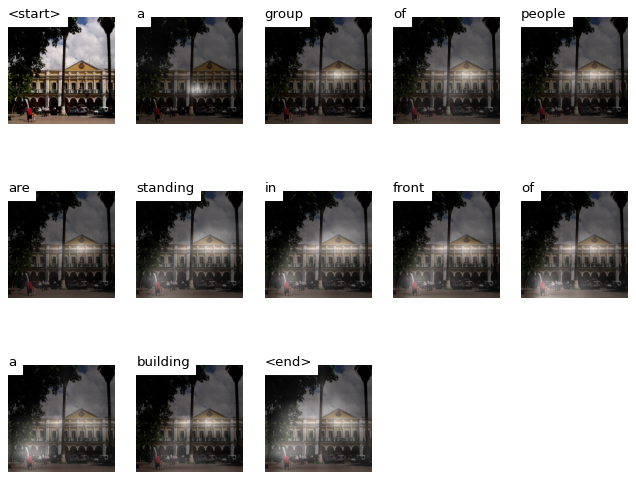

Generating captions and attention...:  10%|████▌                                         | 1/10 [00:02<00:19,  2.19s/it]

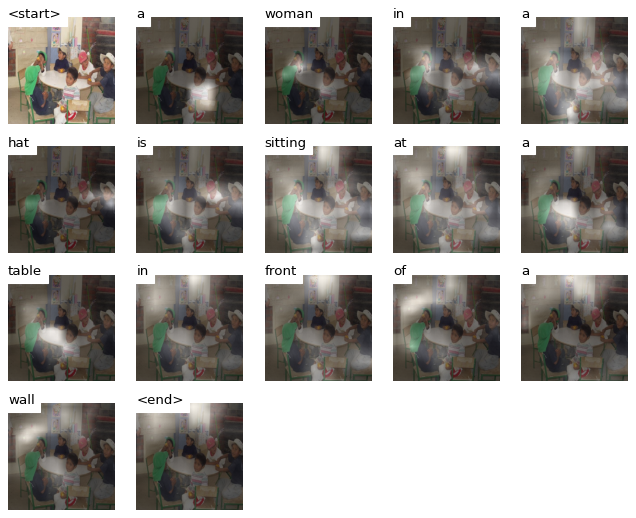

Generating captions and attention...:  20%|█████████▏                                    | 2/10 [00:04<00:20,  2.55s/it]

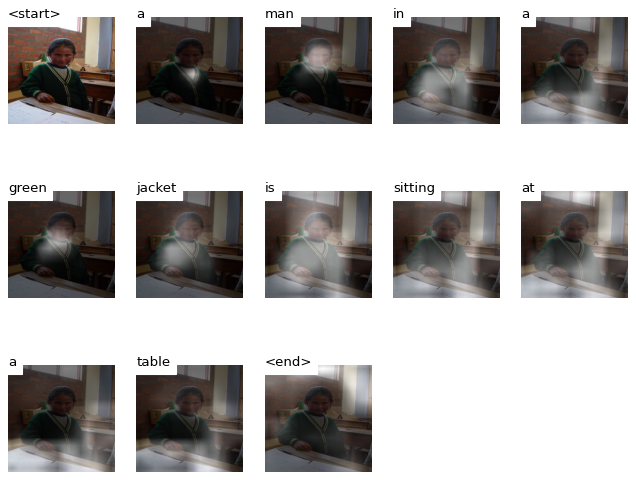

Generating captions and attention...:  30%|█████████████▊                                | 3/10 [00:07<00:16,  2.31s/it]

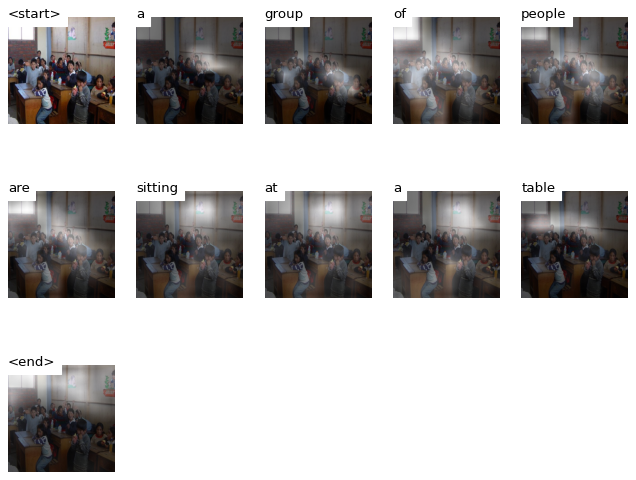

Generating captions and attention...:  40%|██████████████████▍                           | 4/10 [00:08<00:12,  2.12s/it]

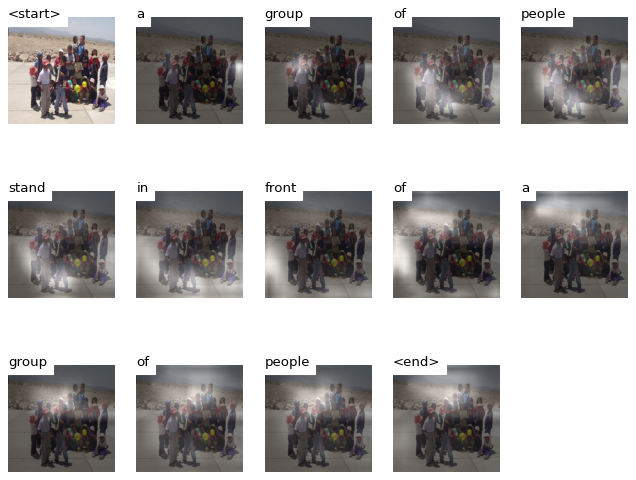

Generating captions and attention...:  50%|███████████████████████                       | 5/10 [00:11<00:10,  2.18s/it]

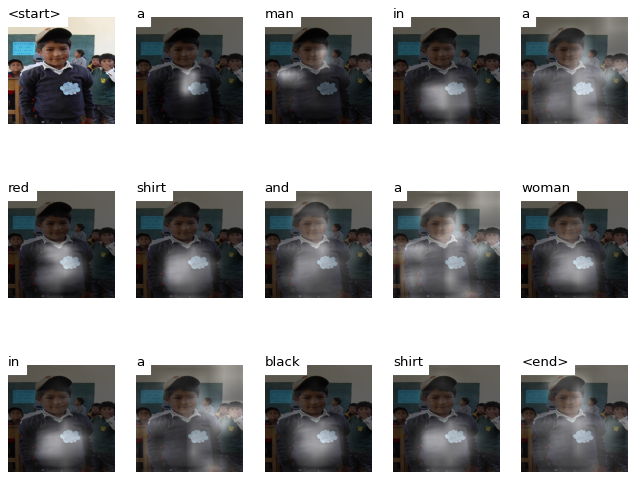

Generating captions and attention...:  60%|███████████████████████████▌                  | 6/10 [00:13<00:09,  2.29s/it]

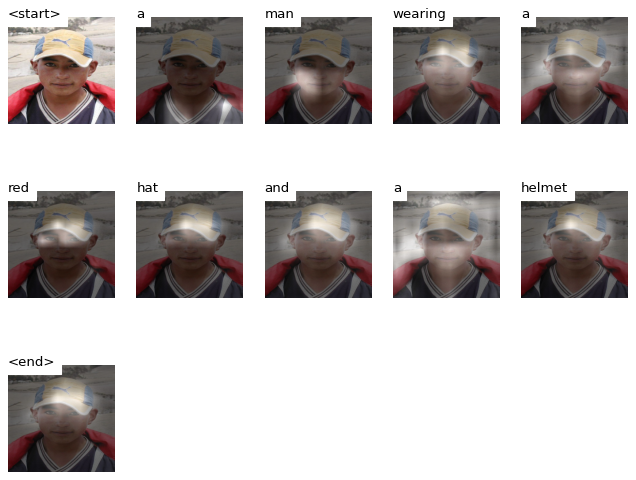

Generating captions and attention...:  70%|████████████████████████████████▏             | 7/10 [00:15<00:06,  2.10s/it]

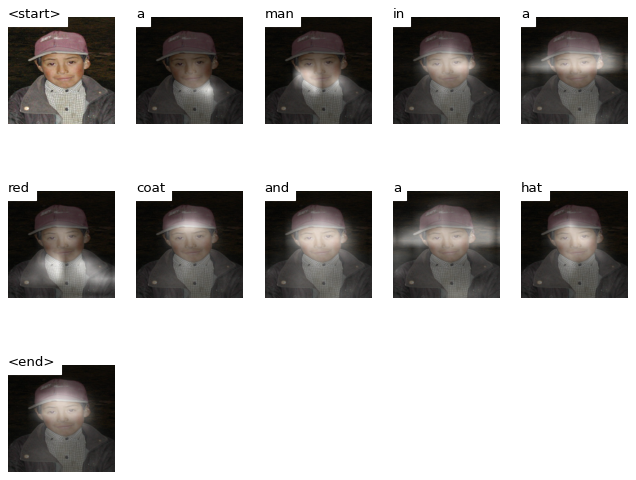

Generating captions and attention...:  80%|████████████████████████████████████▊         | 8/10 [00:17<00:03,  1.97s/it]

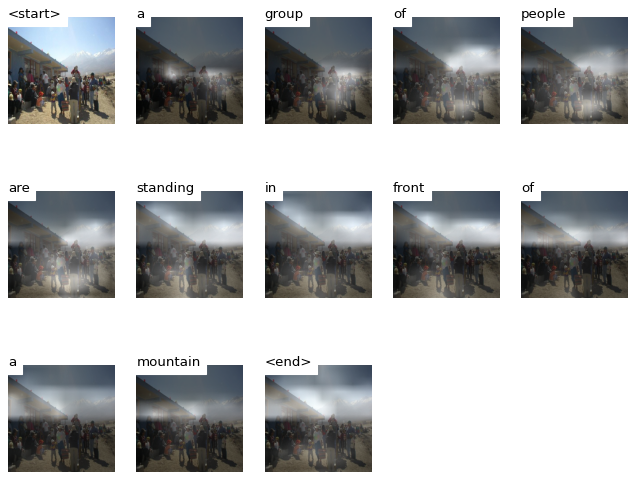

Generating captions and attention...:  90%|█████████████████████████████████████████▍    | 9/10 [00:19<00:01,  2.00s/it]

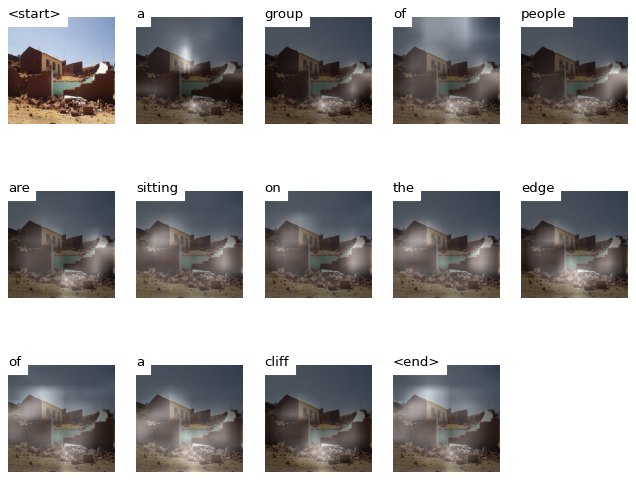

Generating captions and attention...: 100%|█████████████████████████████████████████████| 10/10 [00:21<00:00,  2.12s/it]


In [30]:
tester = CaptionTester(model_path, word_map_path, device, START_TOKEN, END_TOKEN, UNKNOWN_TOKEN)

# generating captions and descriptions for every image in the test dataloader
# in the future can regulate which ones get generated and displayed with if statements
for batch in tqdm(test_dataloader, desc='Generating captions and attention...'):
    img = os.path.join(image_dir, batch['image_paths'][0])
    tester.test_images(img, hyperparameters['beam_size'], hyperparameters['smooth'])

# 3 - Fine-tuning the model (by Nikolai Ilinykh)
This part is mostly done by Nikolai, adapted for our use by Maria (changes marked by comments in the code), with individual contributions from Dominik marked in the code.

In [ ]:
def main(checkpoint_path, model_name):
    """
    Training and validation.
    """

    # Read word map
    with open(word_map_path, 'r') as j:
        word_map = json.load(j)

#removing initializing model

    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_bleu4 = checkpoint['bleu-4']
    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    if training_parameters['fine_tune_encoder'] is True and encoder_optimizer is None:
        encoder.fine_tune(training_parameters['fine_tune_encoder'])
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=training_parameters['encoder_lr'])

    trainer = CaptionTrainer(decoder, encoder, word_map, device, training_parameters)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Custom dataloaders
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_loader = torch.utils.data.DataLoader(
        train_set,  
        shuffle=True, 
        collate_fn=custom_collate, 
        drop_last=True,
        batch_size=training_parameters['batch_size'],
        num_workers=training_parameters['workers'],
        pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        train_set,  # TODO change to val_set later!!!  
        shuffle=True, 
        collate_fn=custom_collate, 
        drop_last=True,
        batch_size=training_parameters['batch_size'],
        num_workers=training_parameters['workers'],
        pin_memory=True)

    # Epochs
    for epoch in range(start_epoch, training_parameters['epochs']):

        # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if training_parameters['fine_tune_encoder']:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # One epoch's training
        trainer.train(train_loader=train_loader,
                      criterion=criterion,
                      encoder_optimizer=encoder_optimizer,
                      decoder_optimizer=decoder_optimizer,
                      epoch=epoch)

        # One epoch's validation
        recent_bleu4 = trainer.validate(val_loader=val_loader,
                                        criterion=criterion)

        # Check if there was an improvement
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        # Save checkpoint - needed since the original function did not allow for a path
        state = {'epoch': epoch,
                 'epochs_since_improvement': epochs_since_improvement,
                 'bleu-4': recent_bleu4,
                 'encoder': encoder,
                 'decoder': decoder,
                 'encoder_optimizer': encoder_optimizer,
                 'decoder_optimizer': decoder_optimizer}
        filename = 'checkpoint_' + model_name + '.pth.tar'
        torch.save(state, filename)
        # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
        if is_best:
            torch.save(state, saved_root_dir + 'BEST_' + filename)

In [ ]:
main(model_path, 'imageCLEF')

# 4 - Testing the fine-tuned model
Again, with a lot of the code based on Nikolai's work, a significant portion of this is analogous to the testing of the non-finetuned model done by Maria, and with contributions by Dominik.

In [33]:
finetuned_path = os.path.join(saved_root_dir, 'checkpoint_imageCLEF.pth.tar')

# creating a dataloader for testing purposes, batch size 1 for ease of testing, no shuffle is needed, no drop last is needed
test_loader = DataLoader(
    test_set, 
    1, 
    shuffle=False, 
    collate_fn=custom_collate, 
)

Generating captions and attention...:   0%|                                                      | 0/10 [00:00<?, ?it/s]

../data/iaprtc12/images/00/25.jpg


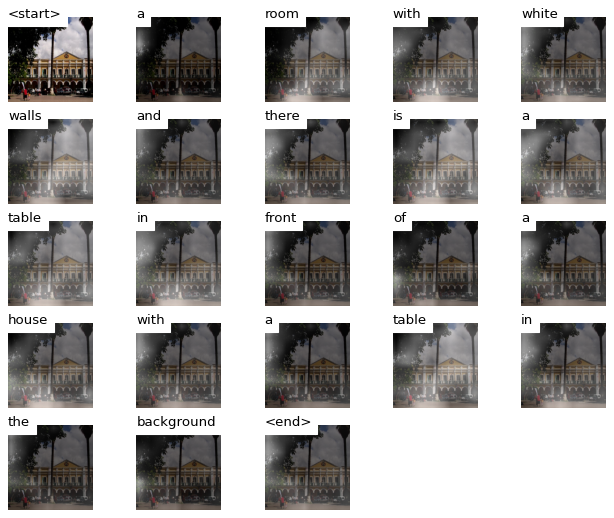

Generating captions and attention...:  10%|████▌                                         | 1/10 [00:03<00:31,  3.48s/it]

../data/iaprtc12/images/00/712.jpg


/tmp/ipykernel_15099/1667324652.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  plt.imshow(Image.open(img).resize([24 * 38, 24 * 38], Image.LANCZOS))
Generating captions and attention...:  20%|█████████▏                                    | 2/10 [00:04<00:15,  1.97s/it]

../data/iaprtc12/images/00/831.jpg


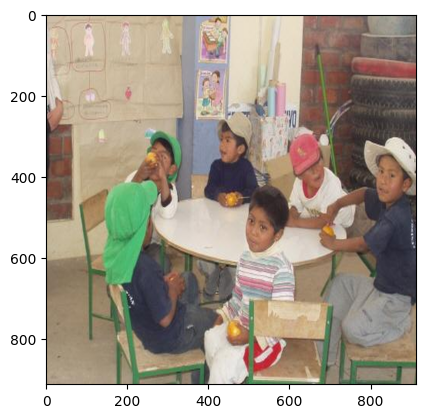

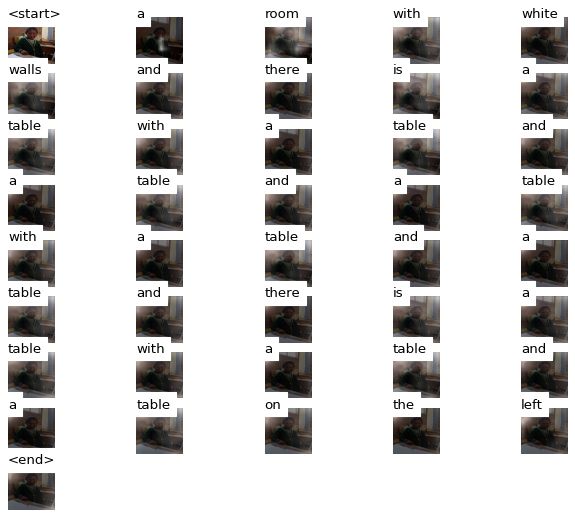

Generating captions and attention...:  30%|█████████████▊                                | 3/10 [00:09<00:22,  3.19s/it]

../data/iaprtc12/images/00/684.jpg


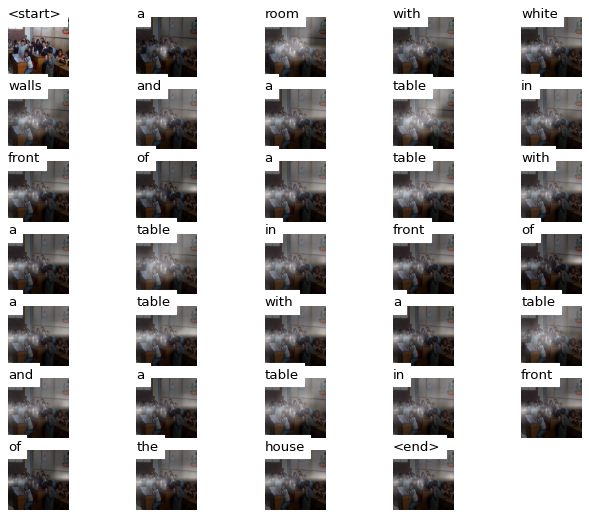

Generating captions and attention...:  40%|██████████████████▍                           | 4/10 [00:13<00:22,  3.70s/it]

../data/iaprtc12/images/00/768.jpg


Generating captions and attention...:  50%|███████████████████████                       | 5/10 [00:14<00:13,  2.79s/it]

../data/iaprtc12/images/00/895.jpg


Generating captions and attention...:  60%|███████████████████████████▌                  | 6/10 [00:15<00:08,  2.11s/it]

../data/iaprtc12/images/00/938.jpg


Generating captions and attention...:  70%|████████████████████████████████▏             | 7/10 [00:16<00:04,  1.64s/it]

../data/iaprtc12/images/00/932.jpg


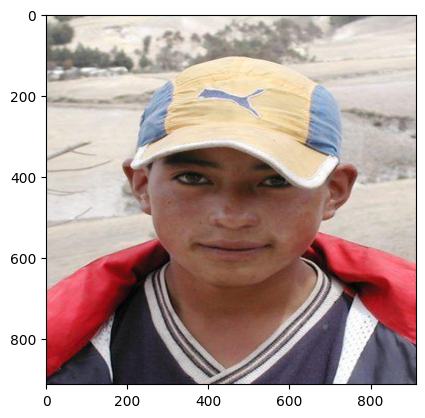

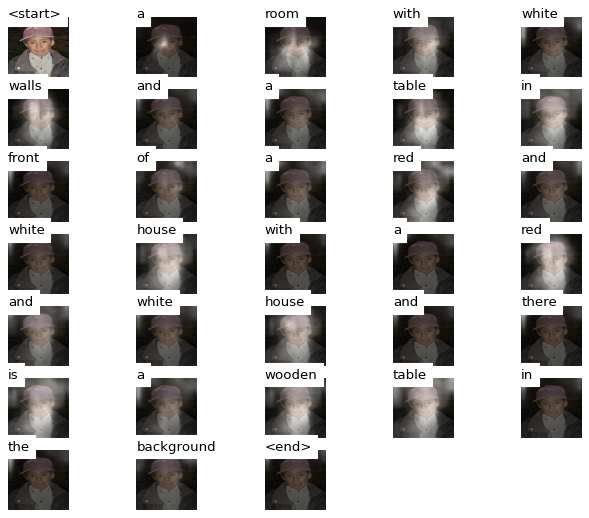

Generating captions and attention...:  80%|████████████████████████████████████▊         | 8/10 [00:20<00:05,  2.57s/it]

../data/iaprtc12/images/00/690.jpg


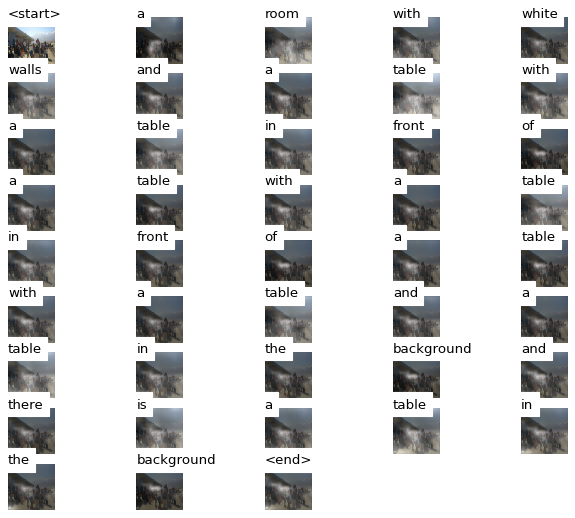

Generating captions and attention...:  90%|█████████████████████████████████████████▍    | 9/10 [00:25<00:03,  3.28s/it]

../data/iaprtc12/images/00/709.jpg


Generating captions and attention...: 100%|█████████████████████████████████████████████| 10/10 [00:26<00:00,  2.66s/it]


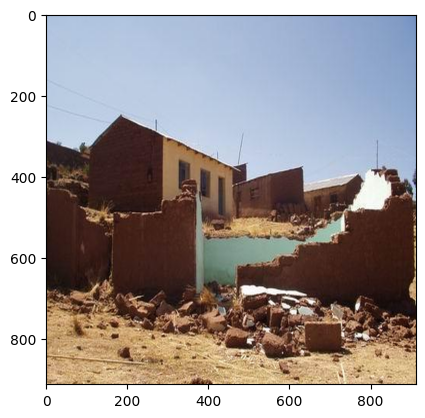

In [34]:
tester = CaptionTester(finetuned_path, word_map_path, device, START_TOKEN, END_TOKEN, UNKNOWN_TOKEN)

# generating captions and descriptions for every image in the test dataloader
# in the future can regulate which ones get generated and displayed with if statements
for batch in tqdm(test_loader, desc='Generating captions and attention...'):
    img = os.path.join(image_dir, batch['image_paths'][0])
    print(img)
    try:
        tester.test_images(img, hyperparameters['beam_size'], hyperparameters['smooth'])
    except ValueError as e:
        plt.imshow(Image.open(img).resize([24 * 38, 24 * 38], Image.LANCZOS))